In [16]:
pip install pyspark findspark

Note: you may need to restart the kernel to use updated packages.


In [17]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FlightDelay").getOrCreate()


In [18]:
df = spark.read.csv("D:/scala/DelayedFlights.csv", header=True, inferSchema=True)
df.show(5)

+---+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|_c0|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|  0|2008|    1|         3|        4| 2003.0|      1955| 2211.0|      2225|       

In [19]:
from pyspark.sql.functions import mean
#Handle Missing Values
numeric_cols = ["ArrDelay", "DepDelay", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]

for col in numeric_cols:
    mean_val = df.select(mean(col)).collect()[0][0]
    df = df.fillna({col: mean_val})

df = df.dropna(subset=["UniqueCarrier", "Origin", "Dest"])


In [20]:
df = df.drop("CarrierIndex", "OriginIndex", "DestIndex")

# Re-index categorical columns
from pyspark.ml.feature import StringIndexer

carrier_indexer = StringIndexer(inputCol="UniqueCarrier", outputCol="CarrierIndex")
origin_indexer = StringIndexer(inputCol="Origin", outputCol="OriginIndex")
dest_indexer = StringIndexer(inputCol="Dest", outputCol="DestIndex")

df = carrier_indexer.fit(df).transform(df)
df = origin_indexer.fit(df).transform(df)
df = dest_indexer.fit(df).transform(df)


In [21]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["CarrierIndex", "OriginIndex", "DestIndex", "DepDelay", "Distance"],
    outputCol="features"
)

df = assembler.transform(df)

In [22]:
from pyspark.sql.functions import when

df = df.withColumn("Delayed", when(df["ArrDelay"] > 0, 1).otherwise(0))

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

# Increase maxBins to handle high-cardinality categorical features
dt = DecisionTreeClassifier(labelCol="Delayed", featuresCol="features", maxBins=1024)

model = dt.fit(df)

predictions = model.transform(df)
predictions.select("Delayed", "prediction", "probability").show(10)


+-------+----------+--------------------+
|Delayed|prediction|         probability|
+-------+----------+--------------------+
|      0|       0.0|[0.56668805919438...|
|      1|       1.0|[0.02847690494083...|
|      1|       1.0|[0.30575922906666...|
|      1|       1.0|[0.02847690494083...|
|      1|       1.0|[0.02847690494083...|
|      1|       1.0|[0.02847690494083...|
|      1|       0.0|[0.56668805919438...|
|      1|       1.0|[0.02847690494083...|
|      1|       1.0|[0.23059543011187...|
|      1|       1.0|[0.02847690494083...|
+-------+----------+--------------------+
only showing top 10 rows


In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("F1 Score:", f1)


Accuracy: 0.8959999132571028
F1 Score: 0.8584508145750306


In [36]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = dt.fit(train_data)
predictions = model.transform(test_data)


In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction", metricName="accuracy")
test_accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", test_accuracy)

test_f1 = evaluator.setMetricName("f1").evaluate(predictions)
print("Test F1 Score:", test_f1)

Test Accuracy: 0.8961184026808154
Test F1 Score: 0.8586149826934397


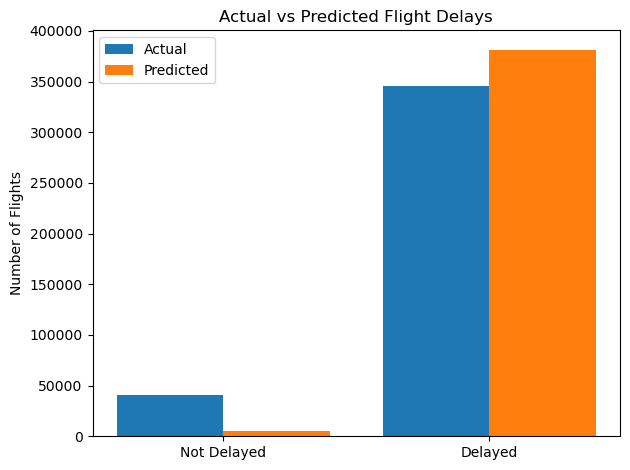

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = predictions.select("Delayed", "prediction").toPandas()

actual_counts = pdf["Delayed"].value_counts().sort_index()
predicted_counts = pdf["prediction"].value_counts().sort_index()

labels = [0, 1]
actual = [actual_counts.get(i, 0) for i in labels]
predicted = [predicted_counts.get(i, 0) for i in labels]

x = range(len(labels))
plt.bar(x, actual, width=0.4, label='Actual', align='center')
plt.bar([i + 0.4 for i in x], predicted, width=0.4, label='Predicted', align='center')

plt.xticks([i + 0.2 for i in x], ['Not Delayed', 'Delayed'])
plt.ylabel('Number of Flights')
plt.title('Actual vs Predicted Flight Delays')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
dashboard_data = predictions.select(
    "Year", "Month", "UniqueCarrier", "Origin", "Dest", 
    "DepDelay", "ArrDelay", "Delayed", "prediction", "probability"
).toPandas()

dashboard_data['Correct_Prediction'] = (dashboard_data['Delayed'] == dashboard_data['prediction']).astype(int)

dashboard_data.to_excel("flight_delay_dashboard_data.xlsx", index=False)